In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from pydicom import dcmread
from pydicom.data import get_testdata_file
from PIL import Image

#from tensorflow.keras import Sequential, layers, models, optimizers
#from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling ?

In [2]:
image = pd.read_csv('../raw_data/train_image_level.csv')
study = pd.read_csv('../raw_data/train_study_level.csv')
df_image = image.copy()
df_study = study.copy()

In [3]:
print(df_image.shape)
df_image.head()

(6334, 4)


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [4]:
print(df_study.shape)
df_study.head()

(6054, 5)


,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [5]:
df_study[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']].value_counts()

Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  Atypical Appearance
0                       1                   0                         0                      2855
1                       0                   0                         0                      1676
0                       0                   1                         0                      1049
                                            0                         1                       474
dtype: int64

## Etude et merge des DF

In [6]:
df_image.isna().sum()

id                     0
boxes               2040
label                  0
StudyInstanceUID       0
dtype: int64

In [7]:
df_image['id'].duplicated().sum()

0

In [8]:
df_image['StudyInstanceUID'].duplicated().sum()

280

**/!\ Il y a 280 duplicats d'ID d'études** (StudyInstanceUID) donc pour lesquels il y a au moins 2 images dans l'étude

In [9]:
df_study.isnull().sum()

id                          0
Negative for Pneumonia      0
Typical Appearance          0
Indeterminate Appearance    0
Atypical Appearance         0
dtype: int64

In [10]:
def clear_id_image(image_id): 
    image_id = image_id.replace('_image','')
    return image_id

def clear_id_study(study_id): 
    study_id = study_id.replace('_study','')
    return study_id

In [11]:
df_image['image_id'] = df_image['id'].apply(clear_id_image)
df_image.head()

,id,boxes,label,StudyInstanceUID,image_id
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891


In [12]:
df_study['StudyInstanceUID'] = df_study['id'].apply(clear_id_study)
df_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,StudyInstanceUID
0,00086460a852_study,0,1,0,0,00086460a852
1,000c9c05fd14_study,0,0,0,1,000c9c05fd14
2,00292f8c37bd_study,1,0,0,0,00292f8c37bd
3,005057b3f880_study,1,0,0,0,005057b3f880
4,0051d9b12e72_study,0,0,0,1,0051d9b12e72


In [13]:
df = (df_image.drop(columns='id')).merge(df_study.drop(columns='id'), on ='StudyInstanceUID', how='left')
print(df.shape)
df.head()

(6334, 8)


,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891,0,1,0,0


In [14]:
df.isna().sum()

boxes                       2040
label                          0
StudyInstanceUID               0
image_id                       0
Negative for Pneumonia         0
Typical Appearance             0
Indeterminate Appearance       0
Atypical Appearance            0
dtype: int64

In [15]:
df[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']].value_counts().sum()

6334

In [16]:
df[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']].value_counts()

Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  Atypical Appearance
0                       1                   0                         0                      3007
1                       0                   0                         0                      1736
0                       0                   1                         0                      1108
                                            0                         1                       483
dtype: int64

## Dataframe simplifié pour tâche de classification seule

In [17]:
df_simple = df.drop(columns=['boxes','label'])
df_simple.head()

,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,5776db0cec75,000a312787f2,0,1,0,0
1,ff0879eb20ed,000c3a3f293f,1,0,0,0
2,9d514ce429a7,0012ff7358bc,0,1,0,0
3,28dddc8559b2,001398f4ff4f,0,0,0,1
4,dfd9fdd85a3e,001bd15d1891,0,1,0,0


In [18]:
df_simple.shape

(6334, 6)

In [19]:
df_simple.isna().sum()

StudyInstanceUID            0
image_id                    0
Negative for Pneumonia      0
Typical Appearance          0
Indeterminate Appearance    0
Atypical Appearance         0
dtype: int64

## Utilisation de la colonne 'boxes'

### Traitement des NaN

In [20]:
df_image['boxes'].isna().sum()

2040

In [21]:
df_nan = df.loc[df_image['boxes'].isna() == True ]
print(df_nan[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']].value_counts())
print(df_nan['label'].value_counts())
df_nan.head(5)

Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  Atypical Appearance
1                       0                   0                         0                      1736
0                       1                   0                         0                       153
                        0                   0                         1                        92
                                            1                         0                        59
dtype: int64
none 1 0 0 1 1    2040
Name: label, dtype: int64


,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0
6,NaN,none 1 0 0 1 1,2fa400b873f5,0023f02ae886,1,0,0,0
22,NaN,none 1 0 0 1 1,1a58b43cf286,00c1515729a8,0,1,0,0
24,NaN,none 1 0 0 1 1,74ba8f2badcb,00e3a7e91a34,1,0,0,0
26,NaN,none 1 0 0 1 1,2a7b4e669dda,010214f9b600,1,0,0,0


**/!\ Les 1736 'Negative for Pneumonia' ont tous NaN dans la colonne 'boxes', mais pas tous les NaN correspondent à 'Negative for Pneumonia'**

Aussi, toutes les boxes NaN ont un label associé 'none 1 0 0 1 1'

### Exportation des infos des boxes

In [22]:
df_no_nan = df.dropna()
print(df_no_nan.shape)
df_no_nan.head(3)

(4294, 8)


,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1


In [23]:
#Formatting bboxes = [[x, y, w, h], [x, y, w, h]] for data augmentation.
df_no_nan['bboxes'] = df_no_nan['boxes'].apply(lambda x: list(list(x.values()) for x in eval(str(x))))
print(df_no_nan.shape)
df_no_nan.head(3)

(4294, 9)


<ipython-input-23-5ed98e481309>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan['bboxes'] = df_no_nan['boxes'].apply(lambda x: list(list(x.values()) for x in eval(str(x))))


,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,bboxes
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,"[[789.28836, 582.43035, 1026.65662, 1917.30292..."
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0,"[[677.42216, 197.97662, 867.79767, 999.78214],..."
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1,"[[2729, 2181.33331, 948.00012, 604]]"


In [28]:
def get_annotations(df): #no_images=5):
    #image_ids = random.choices(df['image_id'].values, k=no_images)
    image_ids = ['65761e66de9f', 'bb4b1da810f3']
    data_path = os.path.join('..','raw_data')
    annotations = []
    for ids in image_ids:
        file_name = ids + '.dcm'
        ds = dcmread(os.path.join(data_path, file_name))
        img = ds.pixel_array
        # Get all the bound boxes as values to 'bboxes'.
        bboxes_imgs = df.loc[df['image_id'] == ids].bboxes.values.tolist()[0]
        # Get all the images as values to 'image' in RGB 3 channels.
        #image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        annotations.append({'image': img, 'bboxes': bboxes_imgs, 'category_id': [1]*len(bboxes_imgs)})
    return annotations

In [26]:
def plot_imgs(annotations, cols=4, size = 7, thickness = 13, img_resize = (500, 500)):
    '''
    function to display image using matplot-lib.
    :param annotations: List of dictionaries containg the image, bboxes and category_ids to plot.
    :param cols: number of columns to use for displaying the images.
    :param size: to determine the size of the total plot w.r.t columns and rows.
    :param thickness: the thickness of the rectangle border [bboxes] line in px. 
    :param img_resize: the new values for changing the size of the image
    '''
    rows = len(annotations)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, annotation in enumerate(annotations):
        img = annotation['image']
        bboxes = annotation['bboxes']
        for box in bboxes:    
            '''
            xmin = xmin
            ymin = ymin
            xmax = xmin + w
            ymax = ymin + h
            '''
            xmin = int(box[0])
            ymin = int(box[1])
            xmax = int((box[0]+box[2]))
            ymax = int((box[1]+box[3]))
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), [255, 0, 0], thickness)
        #img = cv2.resize(img, img_resize)
        ax = fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap = 'gray')
        ax.title.set_text('Image_'+str(i))
    plt.show()

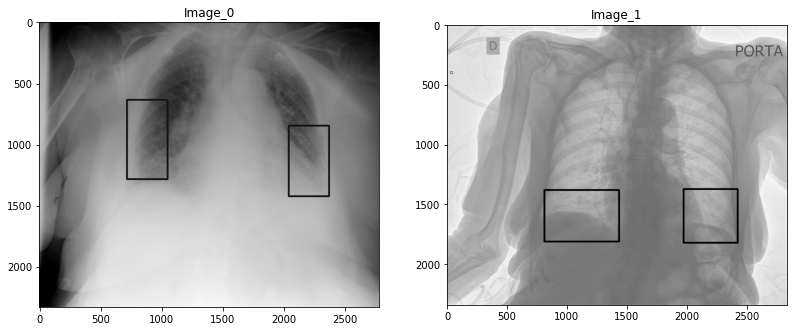

In [29]:
annotations = get_annotations(df_no_nan)
plot_imgs(annotations)

## Fusion avec les datas images

In [30]:
def load_image_data():
    data_path = os.path.join('..','raw_data')
    file_names = [f for f in os.listdir(data_path) if f.endswith('.dcm')]
    image_id = [key_name.replace('.dcm','') for key_name in file_names]
    image_data = []
    for ids,file in zip(image_id, file_names):
        ds = dcmread(os.path.join(data_path, file))
        image_data.append([ids, ds.StudyInstanceUID, ds.PatientSex, ds.Rows, ds.Columns, ds.pixel_array])
    return image_data

In [31]:
image_data = load_image_data()
images_df = pd.DataFrame(image_data, columns=['image_id','image_StudyInstanceUID','Patient_Sex','image_Rows','image_Columns','Pixel_array'])
print(images_df.shape)
images_df.head()

(5, 6)


,image_id,image_StudyInstanceUID,Patient_Sex,image_Rows,image_Columns,Pixel_array
0,65761e66de9f,00086460a852,F,2330,2783,"[[1392, 1389, 1390, 1390, 1350, 1385, 1360, 13..."
1,51759b5579bc,000c9c05fd14,M,3093,2850,"[[82, 81, 80, 81, 79, 80, 81, 78, 79, 77, 76, ..."
2,bb4b1da810f3,0051d9b12e72,F,2336,2836,"[[24335, 24448, 24548, 24551, 24336, 24244, 24..."
3,3019399c31f4,005057b3f880,F,3052,3052,"[[2848, 2863, 2885, 2891, 2899, 2919, 2894, 28..."
4,f6293b1c49e2,00292f8c37bd,M,2539,3050,"[[86, 88, 86, 86, 87, 86, 87, 87, 87, 87, 87, ..."


In [32]:
big_df = df_simple.merge(images_df, on = 'image_id', how='inner')
big_df.head()

,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,image_StudyInstanceUID,Patient_Sex,image_Rows,image_Columns,Pixel_array
0,005057b3f880,3019399c31f4,1,0,0,0,005057b3f880,F,3052,3052,"[[2848, 2863, 2885, 2891, 2899, 2919, 2894, 28..."
1,000c9c05fd14,51759b5579bc,0,0,0,1,000c9c05fd14,M,3093,2850,"[[82, 81, 80, 81, 79, 80, 81, 78, 79, 77, 76, ..."
2,00086460a852,65761e66de9f,0,1,0,0,00086460a852,F,2330,2783,"[[1392, 1389, 1390, 1390, 1350, 1385, 1360, 13..."
3,0051d9b12e72,bb4b1da810f3,0,0,0,1,0051d9b12e72,F,2336,2836,"[[24335, 24448, 24548, 24551, 24336, 24244, 24..."
4,00292f8c37bd,f6293b1c49e2,1,0,0,0,00292f8c37bd,M,2539,3050,"[[86, 88, 86, 86, 87, 86, 87, 87, 87, 87, 87, ..."


In [33]:
X = big_df['Pixel_array']
y = big_df[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']]

In [34]:
print(type(X))
print(X.shape)
len(X)

<class 'pandas.core.series.Series'>
(5,)


5

In [ ]:
#train_val_test_split ??? :

from sklearn.model_selection import train_test_split

def train_val_test_split(X,y):
    X_bis, X_test, y_bis, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_bis, y_bis, test_size=0.2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X,y)

## Modèle réseau de neurones

**/!\ CODE COPIé-COLLé DEPUIS LE COURS : à modifier selon nos conditions /!\**

Reshape les images pour avoir un format commun et réduit à passer dans le modèle?

### Home-designed model

In [ ]:
from tensorflow.keras import Sequential, layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, # input_shape=(256,256,3))) ??

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

model_homemade = load_own_model()
model_homemade.summary()

In [ ]:
# ==> es à modifier selon nos paramètres:
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True) ??

model_homemade.fit(X_train, y_train,
         batch_size=128, 
         epochs=100, 
         validation_data=(X_val, y_val),
         callbacks=[es])

In [ ]:
res = model_homemade.evaluate(X_test, y_test)

In [ ]:
# ==> à modifier avec nos datas:
# print(f'The accuracy is of {res[1]*100:.4f}% compared to a chance level of {1./4*100} %')

**/!\ CODE COPIé-COLLé DEPUIS LE COURS : à modifier selon nos conditions /!\**

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history)

### VGG model

**/!\ CODE COPIé-COLLé DEPUIS LE COURS : à modifier selon nos conditions /!\**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model

model = load_model()
model.summary()

In [ ]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

model = set_nontrainable_layers(model)

model.summary()

In [ ]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
  
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
  
    return model

model = add_last_layers(model)
model.summary()

In [ ]:
def build_model():   
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
    
model = build_model()

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
X_train = preprocess_input(X_train) 
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

print(f'Chance level: {1./num_classes*100:.4f}%')

## Data Augmentation

**/!\ CODE COPIé-COLLé DEPUIS LE COURS : à modifier selon nos conditions /!\**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.5, 1.),
    zoom_range=(0.3, 1.5))


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

model_data_aug = build_model()

train_flow = datagen.flow(X_train, y_train, batch_size=16)
val_flow = datagen.flow(X_val, y_val, batch_size=16)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

history_data_aug = model_data_aug.fit(train_flow,
                                      epochs=50,
                                      validation_data=val_flow, 
                                      callbacks=[es])

In [ ]:
plt.plot(history_data_aug.history['accuracy'])
plt.plot(history_data_aug.history['val_accuracy'])
plt.show()